# Tutorial 2: Analyzing Neural Networks

In this part of the tutorial we'll use the manifold capacity framework to analyze the representations learned by neural networks as we train them on classification tasks. The studies we'll do in this tutorial are inspired by those presented in **[Separability and geometry of object manifolds in deep neural networks](https://www.nature.com/articles/s41467-020-14578-5)**, the follow-up to the original manifold capacity paper that applied the theoretical ideas to real-world machine learning problems. 

We'll use the official code implementation for capacity calculations, so you won't need to copy over your work from Tutorial 1 (but feel free to use it if you want!). We'll be analyzing image classifiers and investigating how the geometry of image representations changes as they are passed through the layers of a trained network.

**Run these cells first!**

In [ ]:
### GOOGLE COLAB SETUP -- ONLY RUN IF WORKING IN COLAB ###
from google.colab import drive
drive.mount('/content/drive')
! git clone https://github.com/SamBT/manifold-capacity-tutorial-iaifi25 
%cd /content/manifold-capacity-tutorial-iaifi25/
! pip install -r requirements.txt

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from tqdm import tqdm
from official_code import manifold_analysis
from mftma.manifold_analysis_correlation import manifold_analysis_corr

## 2.1 - MNIST analysis
Let's start simple by training our own classifier on $28 \times 28$ images of handwritten digits from MNIST. We'll train both a standard MLP and a convolutional neural network and see how they differ using our manifold capacity tools. 

Let's start with the boring stuff -- dataloaders, train/test/val splits, etc

In [30]:
# Define the transformations
mnist_mean = 0.1307
mnist_std = 0.3081
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((mnist_mean,), (mnist_std,))  # MNIST mean and std
])

# Load datasets
train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('./data', train=False, transform=transform)

# Split train into train and validation
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

# useful for later
mnist_labels = np.arange(10)

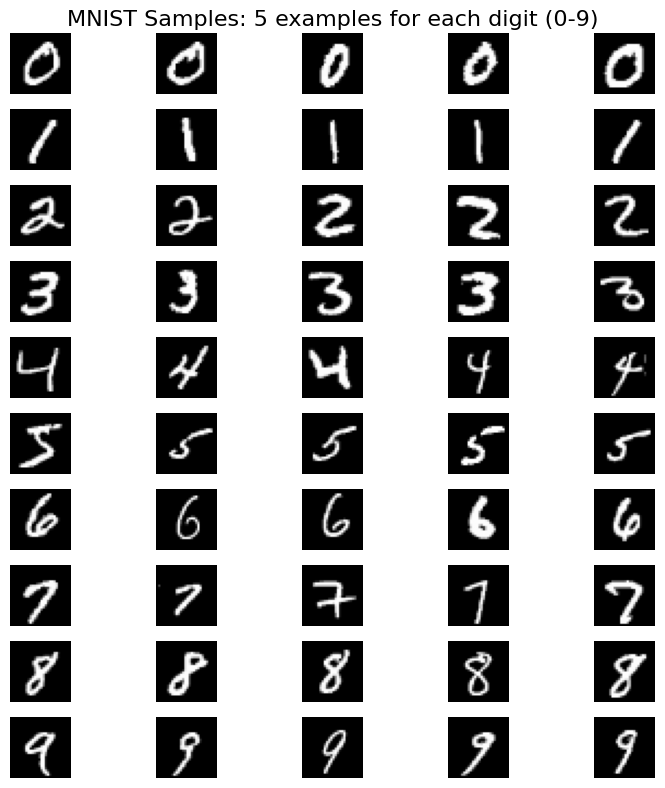

In [31]:
# Define a function to visualize samples from each class
def visualize_mnist_samples(dataset, num_samples_per_class=5):
    # Create a figure with subplots for each class (0-9)
    fig, axes = plt.subplots(10, num_samples_per_class, figsize=(8, 8))
    
    # Dictionary to keep track of samples per class
    class_samples = {i: 0 for i in range(10)}
    
    # Iterate through the dataset until we have enough samples for each class
    for idx in range(len(dataset)):
        # Get image and label
        img, label = dataset[idx]
        
        # If we haven't collected enough samples for this class
        if class_samples[label] < num_samples_per_class:
            # Convert tensor to numpy and reshape
            img_np = img.squeeze().numpy()
            
            # Plot the image
            axes[label, class_samples[label]].imshow(img_np, cmap='gray')
            axes[label, class_samples[label]].axis('off')
            
            # Increment count for this class
            class_samples[label] += 1
        
        # Check if we have collected enough samples for all classes
        if all(count >= num_samples_per_class for count in class_samples.values()):
            break
    
    # Set figure title
    plt.suptitle('MNIST Samples: 5 examples for each digit (0-9)', fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    plt.show()

# Get the original MNIST dataset (not the subset)
original_train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)

# Visualize samples from each class
visualize_mnist_samples(original_train_dataset)

Now let's define a basic MLP for classification

In [2]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim, activation=nn.SiLU(), 
                 output_activation=None, dropout=0.0):
        """
        Multi-Layer Perceptron with configurable architecture
        
        Args:
            input_dim (int): Dimension of input features
            hidden_dims (list): List of hidden layer dimensions
            output_dim (int): Dimension of output
            activation (nn.Module): Activation function for hidden layers
            output_activation (nn.Module): Activation function for output layer (None for no activation)
            dropout (float): Dropout probability between layers (0 to 1)
        """
        super(MLP, self).__init__()
        
        # Build network architecture
        layers = []
        
        # Input layer
        prev_dim = input_dim
        
        # Hidden layers
        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, hidden_dim))
            layers.append(activation)
            if dropout > 0:
                layers.append(nn.Dropout(dropout))
            prev_dim = hidden_dim
        
        # Output layer
        layers.append(nn.Linear(prev_dim, output_dim))
        if output_activation is not None:
            layers.append(output_activation)
        
        # Combine all layers
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        """Forward pass through the network"""
        if len(x.shape) > 2:
            x = x.view(x.shape[0], -1)
        return self.model(x)

Next we define a generic training loop:

In [4]:
def train_model(
    model, 
    train_loader, 
    val_loader, 
    epochs=30, 
    patience=5, 
    learning_rate=0.001, 
    weight_decay=1e-5
):
    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    # Move model to device
    model = model.to(device)
    
    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    
    # For tracking metrics
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    epochs_no_improve = 0
    best_model_weights = None
    
    # Training loop
    for epoch in tqdm(range(epochs), desc="Training Progress"):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            # Statistics
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        epoch_train_loss = running_loss / len(train_loader.dataset)
        epoch_train_acc = correct / total
        train_losses.append(epoch_train_loss)
        
        # Validation phase
        model.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                
                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                # Statistics
                running_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                
        epoch_val_loss = running_loss / len(val_loader.dataset)
        epoch_val_acc = correct / total
        val_losses.append(epoch_val_loss)
        
        # Update tqdm postfix with metrics
        tqdm.write(f"Epoch {epoch+1}/{epochs} - Train loss: {epoch_train_loss:.4f}, Train acc: {epoch_train_acc:.4f}, "
                  f"Val loss: {epoch_val_loss:.4f}, Val acc: {epoch_val_acc:.4f}")
        
        # Check if this is the best model
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            best_model_weights = model.state_dict().copy()
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            
        # Early stopping
        if patience > 0 and epochs_no_improve >= patience:
            print(f"\nEarly stopping triggered after {epoch+1} epochs!")
            break
    
    # Load the best model weights
    if best_model_weights:
        model.load_state_dict(best_model_weights)
        print(f"Loaded best model with validation loss: {best_val_loss:.4f}")
    
    # Plot training and validation loss
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(train_losses)+1), train_losses, label='Training Loss')
    plt.plot(range(1, len(val_losses)+1), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return model, train_losses, val_losses

Lastly, we make a helper function `extract_activations` that extracts internal `Linear` and `Conv2d` activations from a model. You give it a model, a data loader (e.g. over the test set), and tell it how many inputs you want to evaluate, and it will give you a dictionary of the form:

```
activations = {
   "inputs": your input data (flattened), shape (B,d_input),
   "labels": sample labels,
   for i = 1,..., n_layers:
       "linear_i" or "conv_i": activations, # name depends on layer type
}
```


In [5]:
def extract_activations(model, data, labels):
    """
    Extract activations from specified layers of the model for a batch of inputs.
    
    Args:
        model: The trained neural network
        data: A batch of input data

    Returns:
        Dictionary with layer names as keys and activations as values
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()
    
    # Create hooks to capture activations
    activations = {}
    hooks = []
    
    def get_activation(name):
        def hook(model, input, output):
            activations[name] = output.detach().cpu().numpy().reshape(output.shape[0], -1)  # Flatten activations
        return hook
    
    # Register hooks for each layer
    num_linear = 0
    num_conv = 0
    layer_names = []
    for i, layer in enumerate(model.model):
        if isinstance(layer, nn.Linear):
            name = f"linear_{num_linear}"
            num_linear += 1
            hooks.append(model.model[i].register_forward_hook(get_activation(name)))
            layer_names.append(name)
        elif isinstance(layer, nn.Conv2d):
            name = f"conv_{num_conv}"
            num_conv += 1
            hooks.append(model.model[i].register_forward_hook(get_activation(name)))
            layer_names.append(name)
        else:
            continue
    
    # Process data
    all_activations = {name: [] for name in layer_names}
    all_activations['labels'] = labels.cpu().numpy()
    all_activations['inputs'] = data.reshape(data.shape[0], -1).cpu().numpy()  # flatten if inputs are images
    
    with torch.no_grad():
        # evaluate a forward pass to collect activations
        model(data.to(device))
    
    for name in activations.keys():
        all_activations[name] = activations[name]
    
    # Remove hooks
    for hook in hooks:
        hook.remove()

    return all_activations, layer_names

### 2.1.1 - analyze an MLP trained on MNIST

Ok, now it's time for you to write some code. First things first, define an `MLP` (with whatever hyperparameters you want) and, **before training it** use the helper function to evaluate internal activations on a sample of test set images (1000 or so should be fine, no need to do the whole dataset)

#### **FILL IN CODE**

In [41]:
# Initialize an MLP with whatever hyperparameters you think are appropriate
# the output dimension should be 10, since we're doing MNIST classification
input_dim = 28 * 28  # MNIST images are 28x28 pixels
hidden_dims = [1024, 512, 256, 128]
output_dim = 10  # 10 classes (digits 0-9)
mnist_model = MLP(
    input_dim=input_dim,
    hidden_dims=hidden_dims,
    output_dim=output_dim,
    activation=nn.ReLU(),
    dropout=0.2
)

# Define a dataloader for the test set and extract activations for 1000 test samples
num_test_samples = 1000
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=num_test_samples)
test_images, test_labels = next(iter(test_loader))
activations_untrained, layer_names = extract_activations(mnist_model, test_images, test_labels)

Before training, let's use our manifold capacity tools to analyze the input data and the untrained MLP. Samples from each MNIST digit (10 classes, digits 0-9) correspond to our manifold point clouds. We want to compute the manifold capacity, radius, and dimension for each of these classes at each level of processing (input data, 1st layer activations, 2nd layer activations, etc.) and see how they evolve.

**Question**: The network is untrained -- do you expect to see any trends in capacity/radius/dimension as we pass through layers of the network?

### **FILL IN CODE**

In [26]:
def capacity_analysis(activations, layer_names, num_per_label=20, correlation_corrected=False):
    # Get a sorted list of MNIST labels
    labels = sorted(list(set(activations['labels'])))

    alphas = {l:[] for l in labels}
    radii = {l:[] for l in labels}
    dims = {l:[] for l in labels}
    mean_alphas = []
    mean_radii = []
    mean_dims = []

    # loop through the raw inputs + each layer of the network
    for layer_name in ['inputs'] + layer_names:
        print(f"Processing activations for layer: {layer_name}")
        # retrieve corresponding activations
        acts = activations[layer_name]

        # construct point clouds for each mnist class
        point_clouds = []
        for l in labels:
            mask = activations['labels'] == l
            #if np.sum(mask) < num_per_label:
            #    print(f"Not enough samples for label {l} in layer {layer_name}. Found: {np.sum(mask)}, required: {num_per_label}")
            #    continue
            #point_clouds.append(acts[mask][:num_per_label].T)
            point_clouds.append(acts[mask].T)
        
        # compute manifold capacity, radius, and dimension 
        if correlation_corrected:
            alpha, radius, dim, res_coeff0, KK = manifold_analysis_corr(point_clouds, kappa=0, n_t=300)
            alpha = alpha.cpu().numpy()
            radius = radius.cpu().numpy()
            dim = dim.cpu().numpy()
        else:
            alpha, radius, dim = manifold_analysis(point_clouds, kappa=0, n_t=300)

        # fill dictionaries with results
        for i,l in enumerate(labels):
            alphas[l].append(alpha[i])
            radii[l].append(radius[i])
            dims[l].append(dim[i])

        # compute mean values for alpha, radius, and dimension across the mnist classes
        mean_alpha = 1/np.mean(1/alpha)
        mean_radius = np.mean(radius)
        mean_dim = np.mean(dim)
        
        mean_alphas.append(mean_alpha)
        mean_radii.append(mean_radius)
        mean_dims.append(mean_dim)
    return alphas, radii, dims, mean_alphas, mean_radii, mean_dims

In [ ]:
alphas, radii, dims, mean_alphas, mean_radii, mean_dims = capacity_analysis(activations_untrained, layer_names, num_per_label=20)

Now let's plot capacity, radius, and dimension as a function of "depth" -- i.e. the x-axis will be the layer of the MLP, with the first entry corresponding to raw inputs

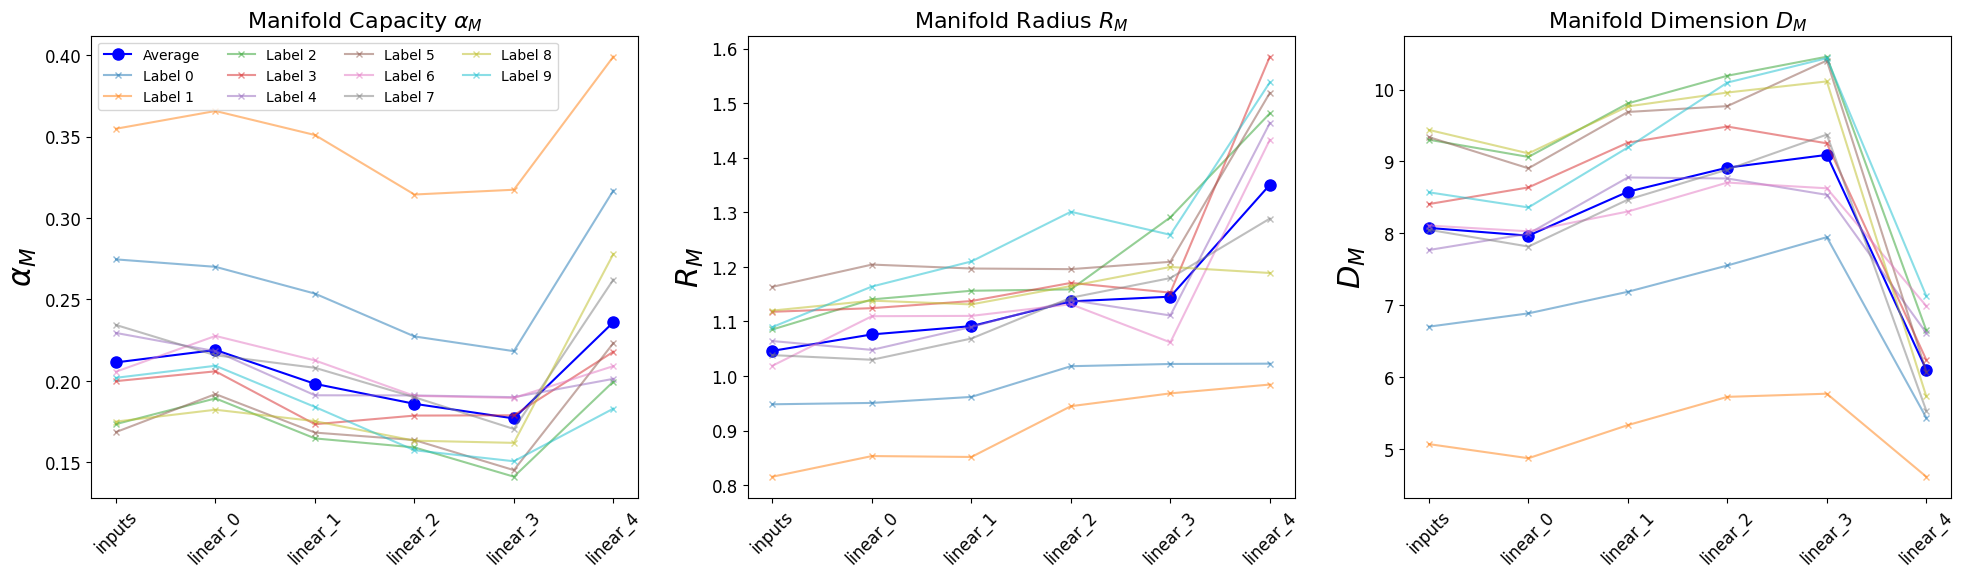

In [43]:
# Create a figure with 3 subplots side by side
fig, axes = plt.subplots(1, 3, figsize=(24, 6))

# X-axis labels for all plots
x_labels = ['inputs'] + layer_names
x_values = np.arange(len(x_labels))

# Plot alpha values (a)
plt.sca(axes[0])
plt.plot(x_values, mean_alphas, 'o-', color='blue', markersize=8,label='Average')
for l in mnist_labels:
    plt.plot(x_values, alphas[l], 'x-', markersize=4, alpha=0.5, label=f'Label {l}')
plt.legend(loc='upper left', fontsize=10,ncol=4)
plt.xticks(x_values, labels=x_labels, rotation=45, fontsize=12)
plt.title(r"Manifold Capacity $\alpha_M$",fontsize=16)
plt.ylabel(r"$\alpha_M$", fontsize=22)
plt.yticks(fontsize=12)

# Plot R values (a)
plt.sca(axes[1])
plt.plot(x_values, mean_radii, 'o-', color='blue', markersize=8)
for l in mnist_labels:
    plt.plot(x_values, radii[l], 'x-', markersize=4, alpha=0.5)
plt.xticks(x_values, labels=x_labels, rotation=45, fontsize=12)
plt.title(r"Manifold Radius $R_M$",fontsize=16)
plt.ylabel(r"$R_M$", fontsize=22)
plt.yticks(fontsize=12)

# Plot D values (a)
plt.sca(axes[2])
plt.plot(x_values, mean_dims, 'o-', color='blue', markersize=8)
for l in mnist_labels:
    plt.plot(x_values, dims[l], 'x-', markersize=4, alpha=0.5)
plt.xticks(x_values, labels=x_labels, rotation=45, fontsize=12)
plt.title(r"Manifold Dimension $D_M$",fontsize=16)
plt.ylabel(r"$D_M$", fontsize=22)
_=plt.yticks(fontsize=12)

There shouldn't be any intelligible trend here, but this is to be expected -- we haven't trained the network yet! Note that the average capacity is pretty low, indicating that the raw pixel values (and a random processing of them by an untrained MLP) is not a super efficient way to encode them! 

**Question**: do you notice anything about the capacity/radius/dimension of the individual digits? What about the number 1?

**Question**: why does the dimension dip in the final layer?

Now, let's train the model!

Using device: cuda


Training Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training Progress:   5%|▌         | 1/20 [00:12<04:03, 12.81s/it]

Epoch 1/20 - Train loss: 0.6933, Train acc: 0.7798, Val loss: 0.2229, Val acc: 0.9292


Training Progress:  10%|█         | 2/20 [00:20<02:57,  9.88s/it]

Epoch 2/20 - Train loss: 0.2055, Train acc: 0.9390, Val loss: 0.1247, Val acc: 0.9609


Training Progress:  15%|█▌        | 3/20 [00:27<02:25,  8.57s/it]

Epoch 3/20 - Train loss: 0.1354, Train acc: 0.9593, Val loss: 0.0969, Val acc: 0.9704


Training Progress:  20%|██        | 4/20 [00:35<02:09,  8.10s/it]

Epoch 4/20 - Train loss: 0.1003, Train acc: 0.9700, Val loss: 0.0851, Val acc: 0.9743


Training Progress:  25%|██▌       | 5/20 [00:42<01:59,  7.97s/it]

Epoch 5/20 - Train loss: 0.0787, Train acc: 0.9766, Val loss: 0.0754, Val acc: 0.9774


Training Progress:  30%|███       | 6/20 [00:50<01:49,  7.82s/it]

Epoch 6/20 - Train loss: 0.0612, Train acc: 0.9822, Val loss: 0.0745, Val acc: 0.9782


Training Progress:  35%|███▌      | 7/20 [00:58<01:44,  8.00s/it]

Epoch 7/20 - Train loss: 0.0490, Train acc: 0.9847, Val loss: 0.0660, Val acc: 0.9806


Training Progress:  40%|████      | 8/20 [01:06<01:36,  8.00s/it]

Epoch 8/20 - Train loss: 0.0440, Train acc: 0.9861, Val loss: 0.0663, Val acc: 0.9808


Training Progress:  45%|████▌     | 9/20 [01:13<01:24,  7.67s/it]

Epoch 9/20 - Train loss: 0.0387, Train acc: 0.9877, Val loss: 0.0732, Val acc: 0.9792


Training Progress:  50%|█████     | 10/20 [01:20<01:14,  7.44s/it]

Epoch 10/20 - Train loss: 0.0354, Train acc: 0.9891, Val loss: 0.0727, Val acc: 0.9801


Training Progress:  55%|█████▌    | 11/20 [01:28<01:08,  7.57s/it]

Epoch 11/20 - Train loss: 0.0298, Train acc: 0.9912, Val loss: 0.0620, Val acc: 0.9833


Training Progress:  60%|██████    | 12/20 [01:35<00:59,  7.38s/it]

Epoch 12/20 - Train loss: 0.0251, Train acc: 0.9916, Val loss: 0.0780, Val acc: 0.9815


Training Progress:  65%|██████▌   | 13/20 [01:43<00:52,  7.49s/it]

Epoch 13/20 - Train loss: 0.0240, Train acc: 0.9925, Val loss: 0.0752, Val acc: 0.9814


Training Progress:  70%|███████   | 14/20 [01:51<00:46,  7.73s/it]

Epoch 14/20 - Train loss: 0.0214, Train acc: 0.9929, Val loss: 0.0759, Val acc: 0.9808


Training Progress:  75%|███████▌  | 15/20 [01:59<00:38,  7.71s/it]

Epoch 15/20 - Train loss: 0.0162, Train acc: 0.9946, Val loss: 0.0713, Val acc: 0.9820


Training Progress:  75%|███████▌  | 15/20 [02:06<00:42,  8.40s/it]


Epoch 16/20 - Train loss: 0.0226, Train acc: 0.9927, Val loss: 0.0809, Val acc: 0.9809

Early stopping triggered after 16 epochs!
Loaded best model with validation loss: 0.0620


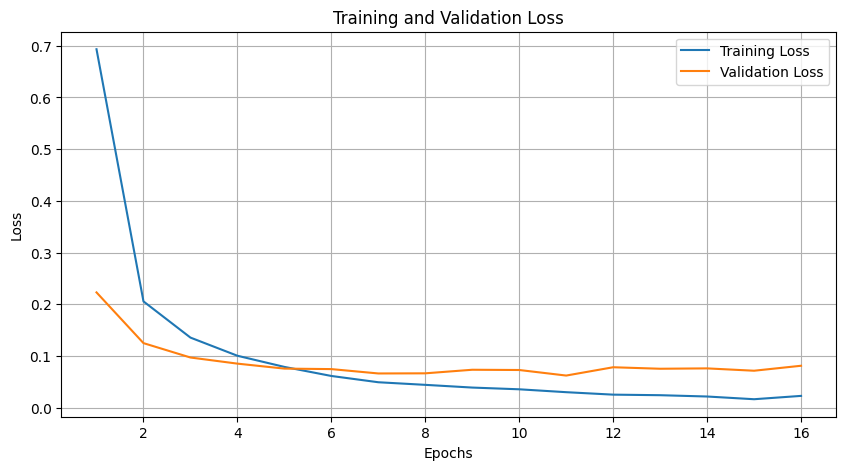

In [44]:
# define train/val/test loaders, choose a batch size
batch_size = 1024
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

# Train the model
trained_model, train_losses, val_losses = train_model(
    model=mnist_model,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=20,
    patience=5,
    learning_rate=0.001
)

Now let's repeat the same analysis we did above

### FILL IN CODE

In [96]:
# Define a dataloader for the test set and extract activations for 1000 test samples
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1000)
test_images, test_labels = next(iter(test_loader))
activations_trained, layer_names = extract_activations(trained_model, test_images, test_labels)

alphas, radii, dims, mean_alphas, mean_radii, mean_dims = capacity_analysis(activations_trained, layer_names)

Processing activations for layer: inputs
Processing activations for layer: linear_0


KeyboardInterrupt: 

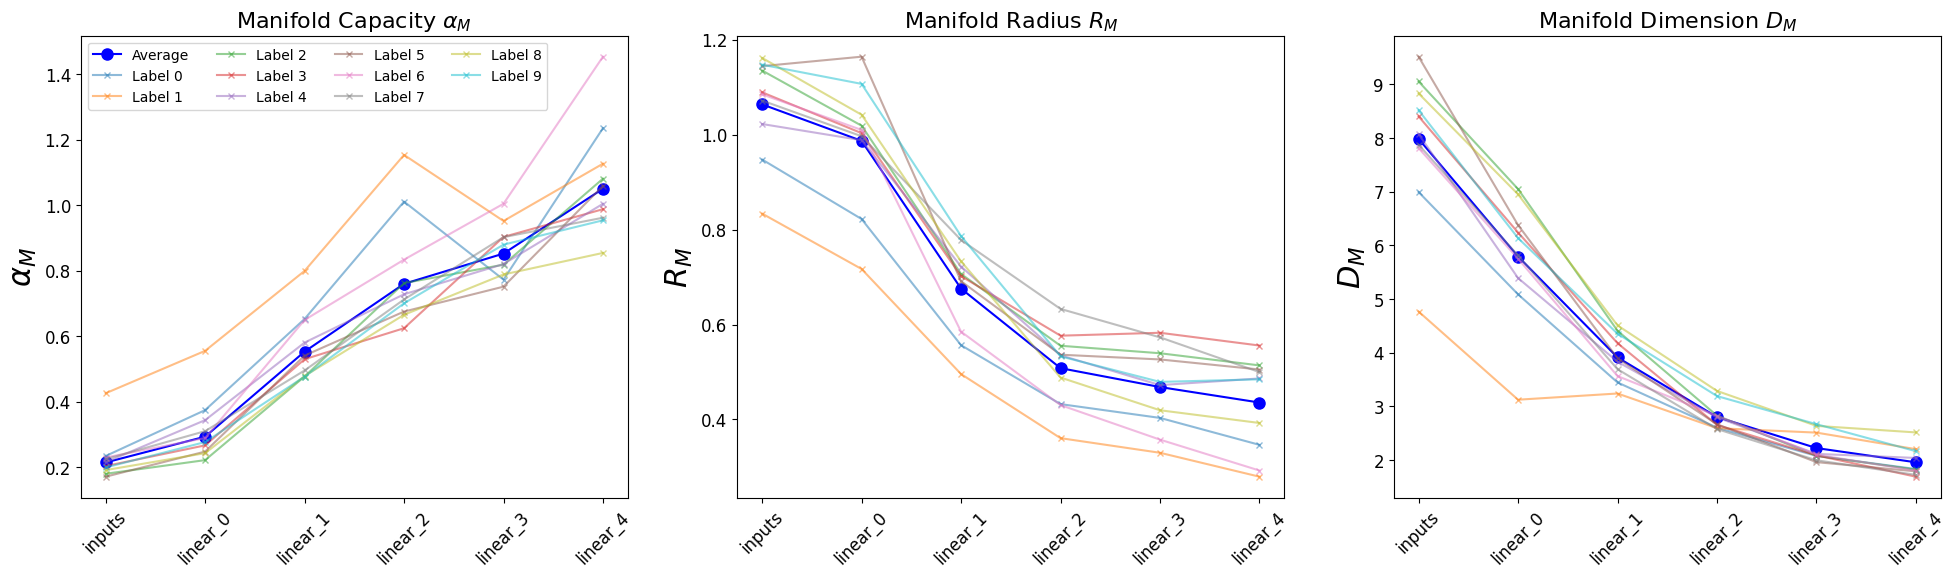

In [56]:
# Create a figure with 3 subplots side by side
fig, axes = plt.subplots(1, 3, figsize=(24, 6))

# X-axis labels for all plots
x_labels = ['inputs'] + layer_names
x_values = np.arange(len(x_labels))
mnist_labels = np.arange(10)

# Plot alpha values (a)
plt.sca(axes[0])
plt.plot(x_values, mean_alphas, 'o-', color='blue', markersize=8,label='Average')
for l in mnist_labels:
    plt.plot(x_values, alphas[l], 'x-', markersize=4, alpha=0.5, label=f'Label {l}')
plt.legend(loc='upper left', fontsize=10,ncol=4)
plt.xticks(x_values, labels=x_labels, rotation=45, fontsize=12)
plt.title(r"Manifold Capacity $\alpha_M$",fontsize=16)
plt.ylabel(r"$\alpha_M$", fontsize=22)
plt.yticks(fontsize=12)

# Plot R values (a)
plt.sca(axes[1])
plt.plot(x_values, mean_radii, 'o-', color='blue', markersize=8)
for l in mnist_labels:
    plt.plot(x_values, radii[l], 'x-', markersize=4, alpha=0.5)
plt.xticks(x_values, labels=x_labels, rotation=45, fontsize=12)
plt.title(r"Manifold Radius $R_M$",fontsize=16)
plt.ylabel(r"$R_M$", fontsize=22)
plt.yticks(fontsize=12)

# Plot D values (a)
plt.sca(axes[2])
plt.plot(x_values, mean_dims, 'o-', color='blue', markersize=8)
for l in mnist_labels:
    plt.plot(x_values, dims[l], 'x-', markersize=4, alpha=0.5)
plt.xticks(x_values, labels=x_labels, rotation=45, fontsize=12)
plt.title(r"Manifold Dimension $D_M$",fontsize=16)
plt.ylabel(r"$D_M$", fontsize=22)
_=plt.yticks(fontsize=12)

What differences do you notice relative to the untrained model? Does this make sense? What can we conclude about the way the neural network has learned to process input images from each digit class?

### 2.1.2 - Augmentation manifolds

Another 

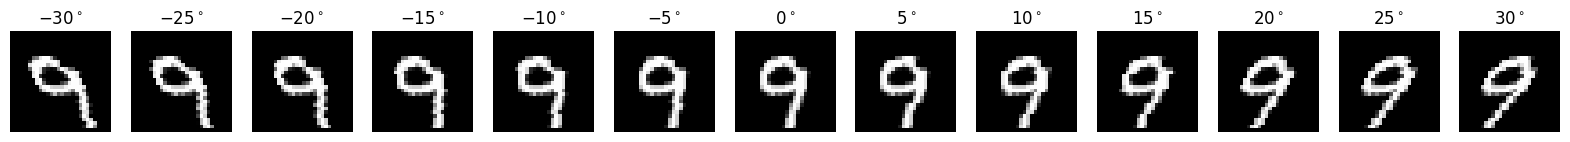

In [57]:
from torchvision.transforms.functional import affine
img,label = train_dataset[90]
shears = np.arange(-30,35,5)
fig,axes = plt.subplots(1, len(shears), figsize=(20, 5))
for i, shear in enumerate(shears):
    # Apply shear transformation
    img_sheared = affine(img, angle=0, translate=(0, 0), scale=1.0, shear=shear, fill=-mnist_mean/mnist_std)
    axes[i].imshow(img_sheared.squeeze().numpy(), cmap='gray')
    axes[i].set_title(f'${shear}^\\circ$',fontsize=12)
    axes[i].axis('off')

Now let's curate a dataset. We want to take one exemplar from each digit class and create an associated augmentation manifold of shear transformations (note that this is different from before, where each class point cloud was just a collection of randomly sampled images from that class)

In [58]:
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100)
test_images, test_labels = next(iter(test_loader))
one_per_class = [test_images[test_labels == l][0] for l in mnist_labels]

# apply shears to each exemplar, create new label set
shears = np.arange(-30, 32, 2)
shear_imgs = []
shear_labels = []
for shear in shears:
    for img, label in zip(one_per_class, mnist_labels):
        # Apply shear transformation
        img_sheared = affine(img, angle=0, translate=(0, 0), scale=1.0, shear=shear, fill=-mnist_mean/mnist_std)
        shear_imgs.append(img_sheared.unsqueeze(0))  # add batch dimension
        shear_labels.append(label)
shear_imgs = torch.cat(shear_imgs, dim=0)
shear_labels = torch.tensor(shear_labels)


Let's analyze the augmentation manifolds using the tools we wrote above and our trained mnist classifier

In [ ]:
activations_shear, layer_names = extract_activations(trained_model, shear_imgs, shear_labels)
alphas, radii, dims, mean_alphas, mean_radii, mean_dims = capacity_analysis(activations_shear, layer_names)

Processing activations for layer: inputs
Processing activations for layer: linear_0
Processing activations for layer: linear_1
Processing activations for layer: linear_2
Processing activations for layer: linear_3
Processing activations for layer: linear_4


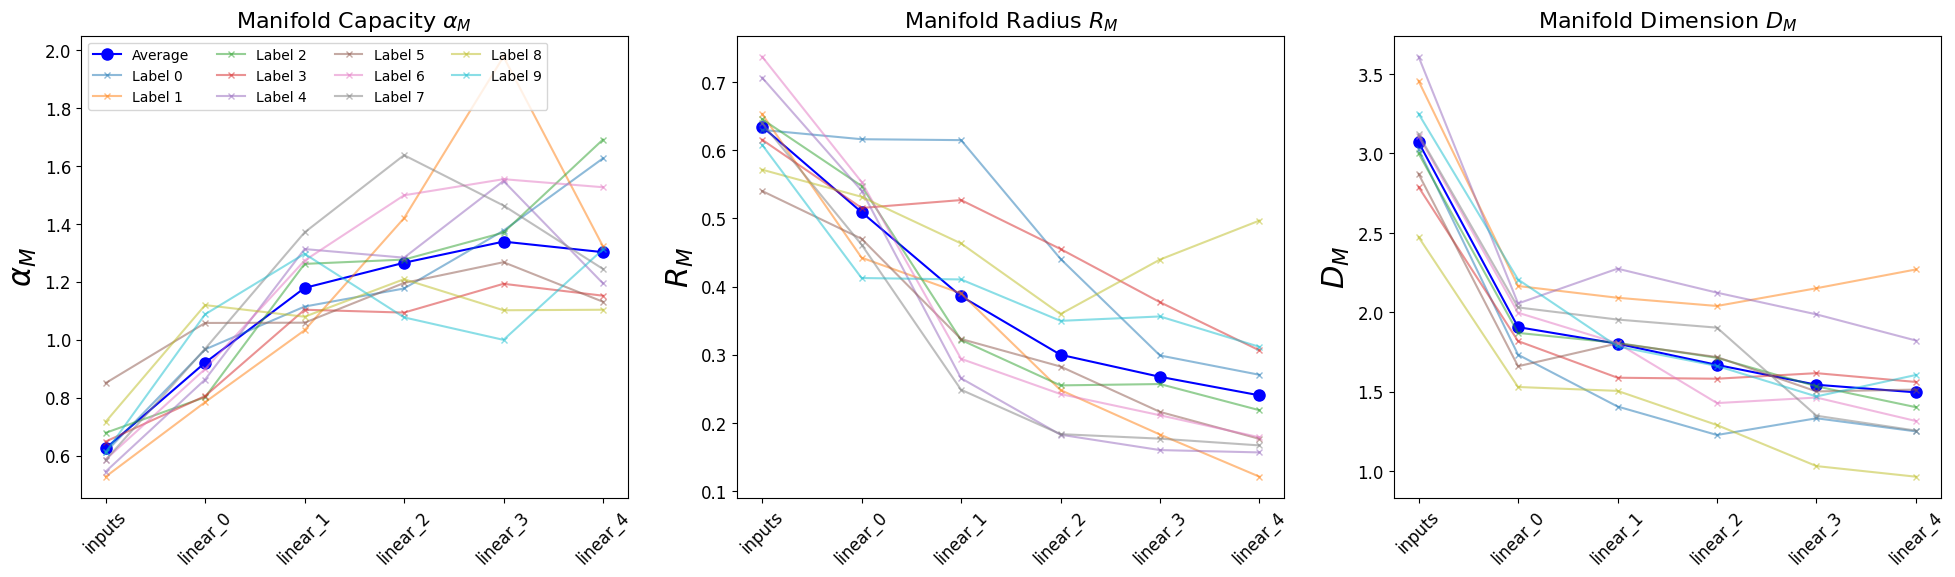

In [60]:
# Create a figure with 3 subplots side by side
fig, axes = plt.subplots(1, 3, figsize=(24, 6))

# X-axis labels for all plots
x_labels = ['inputs'] + layer_names
x_values = np.arange(len(x_labels))
mnist_labels = np.arange(10)

# Plot alpha values (a)
plt.sca(axes[0])
plt.plot(x_values, mean_alphas, 'o-', color='blue', markersize=8,label='Average')
for l in mnist_labels:
    plt.plot(x_values, alphas[l], 'x-', markersize=4, alpha=0.5, label=f'Label {l}')
plt.legend(loc='upper left', fontsize=10,ncol=4)
plt.xticks(x_values, labels=x_labels, rotation=45, fontsize=12)
plt.title(r"Manifold Capacity $\alpha_M$",fontsize=16)
plt.ylabel(r"$\alpha_M$", fontsize=22)
plt.yticks(fontsize=12)

# Plot R values (a)
plt.sca(axes[1])
plt.plot(x_values, mean_radii, 'o-', color='blue', markersize=8)
for l in mnist_labels:
    plt.plot(x_values, radii[l], 'x-', markersize=4, alpha=0.5)
plt.xticks(x_values, labels=x_labels, rotation=45, fontsize=12)
plt.title(r"Manifold Radius $R_M$",fontsize=16)
plt.ylabel(r"$R_M$", fontsize=22)
plt.yticks(fontsize=12)

# Plot D values (a)
plt.sca(axes[2])
plt.plot(x_values, mean_dims, 'o-', color='blue', markersize=8)
for l in mnist_labels:
    plt.plot(x_values, dims[l], 'x-', markersize=4, alpha=0.5)
plt.xticks(x_values, labels=x_labels, rotation=45, fontsize=12)
plt.title(r"Manifold Dimension $D_M$",fontsize=16)
plt.ylabel(r"$D_M$", fontsize=22)
_=plt.yticks(fontsize=12)

What do you notice about these results? Is it what you expected? Shears are fairly "natural" transformations for handwritten digits -- everyone writes numbers a little differently, and a sharply angled "1" or "7" is not out of the realm of possibility (and probably exists in the MNIST training set!). 

#### **Exercise**
Repeat this analysis with more "aggressive" augmentations such as translations or rotations (i.e. ones that ). You can do this using the same affine transformation function we used above, just change the arguments. What's different this time?

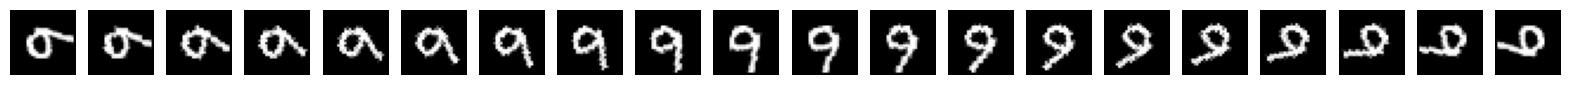

In [67]:
from torchvision.transforms.functional import affine
img,label = train_dataset[90]
angles = list(np.linspace(-90,90,20))
fig,axes = plt.subplots(1, len(angles), figsize=(20, 5))
for i, angle in enumerate(angles):
    # Apply shear transformation
    img_sheared = affine(img, angle=angle, translate=(0, 0), scale=1.0, shear=0, fill=-mnist_mean/mnist_std)
    axes[i].imshow(img_sheared.squeeze().numpy(), cmap='gray')
    #axes[i].set_title(f'${angle}^\\circ$',fontsize=12)
    axes[i].axis('off')

In [ ]:
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100)
test_images, test_labels = next(iter(test_loader))
one_per_class = [test_images[test_labels == l][0] for l in mnist_labels]

# apply shears to each exemplar, create new label set
angles = np.linspace(-90,90,20)
rot_imgs = []
rot_labels = []
for angle in angles:
    for img, label in zip(one_per_class, mnist_labels):
        # Apply rotation transformation
        img_rotated = affine(img, angle=angle, translate=(0, 0), scale=1.0, shear=0, fill=-mnist_mean/mnist_std)
        rot_imgs.append(img_rotated.unsqueeze(0))  # add batch dimension
        rot_labels.append(label)
rot_imgs = torch.cat(rot_imgs, dim=0)
rot_labels = torch.tensor(rot_labels)


In [84]:
activations_rot, layer_names = extract_activations(trained_model, rot_imgs, rot_labels)
alphas, radii, dims, mean_alphas, mean_radii, mean_dims = capacity_analysis(activations_rot, layer_names)

Processing activations for layer: inputs
Processing activations for layer: linear_0
Processing activations for layer: linear_1
Processing activations for layer: linear_2
Processing activations for layer: linear_3
Processing activations for layer: linear_4


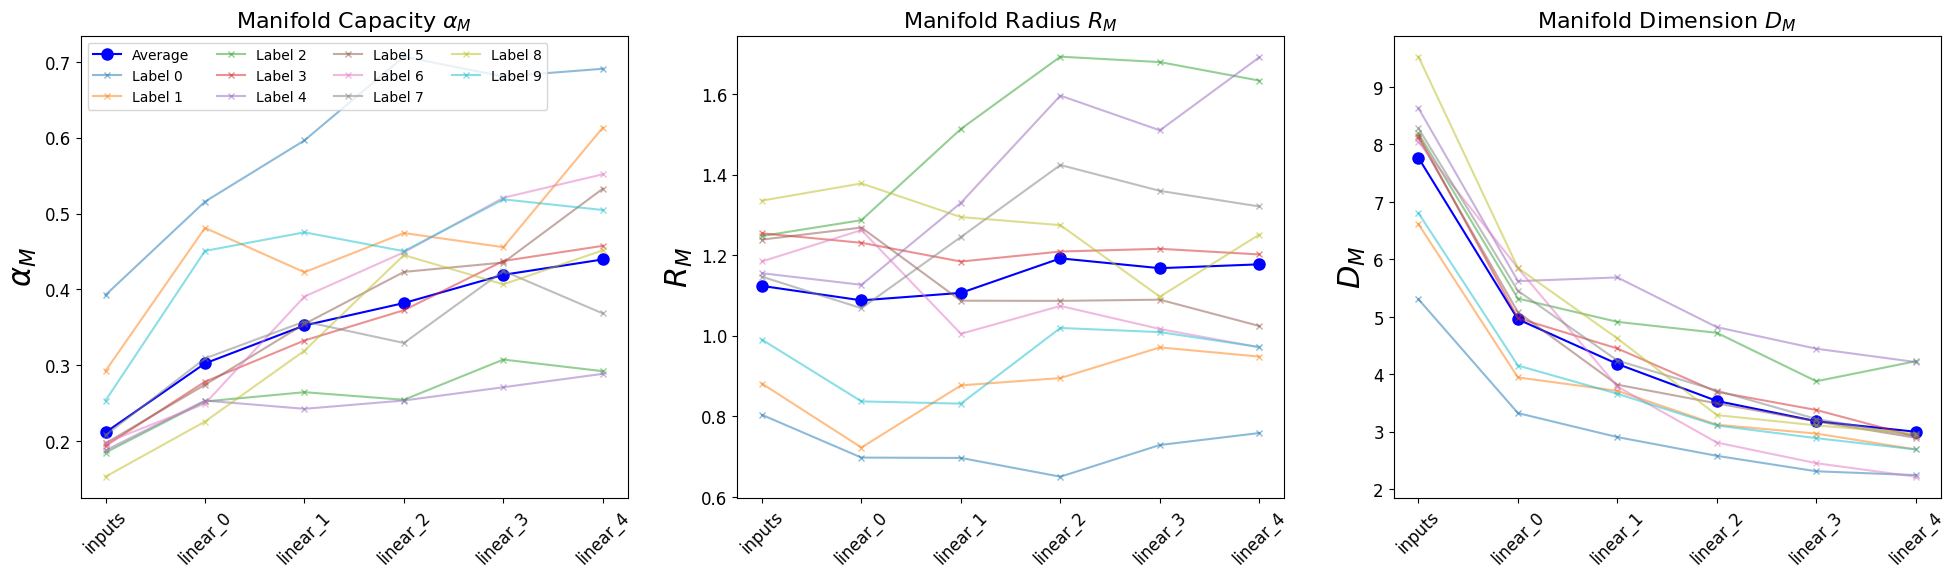

In [85]:
# Create a figure with 3 subplots side by side
fig, axes = plt.subplots(1, 3, figsize=(24, 6))

# X-axis labels for all plots
x_labels = ['inputs'] + layer_names
x_values = np.arange(len(x_labels))
mnist_labels = np.arange(10)

# Plot alpha values (a)
plt.sca(axes[0])
plt.plot(x_values, mean_alphas, 'o-', color='blue', markersize=8,label='Average')
for l in mnist_labels:
    plt.plot(x_values, alphas[l], 'x-', markersize=4, alpha=0.5, label=f'Label {l}')
plt.legend(loc='upper left', fontsize=10,ncol=4)
plt.xticks(x_values, labels=x_labels, rotation=45, fontsize=12)
plt.title(r"Manifold Capacity $\alpha_M$",fontsize=16)
plt.ylabel(r"$\alpha_M$", fontsize=22)
plt.yticks(fontsize=12)

# Plot R values (a)
plt.sca(axes[1])
plt.plot(x_values, mean_radii, 'o-', color='blue', markersize=8)
for l in mnist_labels:
    plt.plot(x_values, radii[l], 'x-', markersize=4, alpha=0.5)
plt.xticks(x_values, labels=x_labels, rotation=45, fontsize=12)
plt.title(r"Manifold Radius $R_M$",fontsize=16)
plt.ylabel(r"$R_M$", fontsize=22)
plt.yticks(fontsize=12)

# Plot D values (a)
plt.sca(axes[2])
plt.plot(x_values, mean_dims, 'o-', color='blue', markersize=8)
for l in mnist_labels:
    plt.plot(x_values, dims[l], 'x-', markersize=4, alpha=0.5)
plt.xticks(x_values, labels=x_labels, rotation=45, fontsize=12)
plt.title(r"Manifold Dimension $D_M$",fontsize=16)
plt.ylabel(r"$D_M$", fontsize=22)
_=plt.yticks(fontsize=12)

### 2.1.3 - CNN analysis (optional)

As you likely know, MLPs are generally pretty bad for image classification (MNIST just happens to be an "easy" dataset). Convolutional neural networks (CNNs) are a much better choice, and most of the best image classifiers from the past decade (e.g. ResNet) are CNNs. Convolutions also have nice geometric properties: they are **translation equivariant**, and when combined with some kind of global pooling (e.g. mean/max) a CNN can be translation **invariant**. 

In the cell below we define a basic CNN architecture sufficient for MNIST classification. Try training it and doing the same analysis as we did for the MLP above. In particular, try constructing an augmentation manifold from **translations**, and track how the capacity/radius/dimension of this manifold vary through layers of the network (particularly before/after the global pooling).

In [88]:
class CNN(nn.Module):
    def __init__(self):
        """
        Convolutional Neural Network for MNIST classification
        """
        super(CNN, self).__init__()
        
        # Convolutional layers
        self.model = nn.Sequential(
            # First conv block: 1 -> 16 channels
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Second conv block: 16 -> 32 channels
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Flatten the features
            nn.Flatten(),
            
            # Fully connected layers
            nn.Linear(32 * 7 * 7, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            
            # Output layer
            nn.Linear(128, 10)
        )

        self.model = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),  # 28x28 -> 28x28
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, padding=1), # 28x28 -> 28x28
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),                             # 28x28 -> 14x14

            nn.Conv2d(64, 128, kernel_size=3, padding=1), # 14x14 -> 14x14
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),# 14x14 -> 14x14
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),                              # 14x14 -> 7x7

            # pooling
            nn.AdaptiveAvgPool2d((1, 1)),                 # 7x7 -> 1x1

            # fully connected layer,
            nn.Flatten(),
            nn.Linear(128, 10)
        )


    def forward(self, x):
        """Forward pass through the network"""
        return self.model(x)

Using device: cuda


Training Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training Progress:   5%|▌         | 1/20 [00:17<05:37, 17.78s/it]

Epoch 1/20 - Train loss: 1.1581, Train acc: 0.7727, Val loss: 0.6187, Val acc: 0.9234


Training Progress:  10%|█         | 2/20 [00:25<03:37, 12.11s/it]

Epoch 2/20 - Train loss: 0.2919, Train acc: 0.9635, Val loss: 0.2259, Val acc: 0.9649


Training Progress:  15%|█▌        | 3/20 [00:34<02:54, 10.28s/it]

Epoch 3/20 - Train loss: 0.1414, Train acc: 0.9779, Val loss: 0.1687, Val acc: 0.9692


Training Progress:  20%|██        | 4/20 [00:41<02:29,  9.36s/it]

Epoch 4/20 - Train loss: 0.0939, Train acc: 0.9842, Val loss: 0.1418, Val acc: 0.9663


Training Progress:  25%|██▌       | 5/20 [00:50<02:15,  9.06s/it]

Epoch 5/20 - Train loss: 0.0696, Train acc: 0.9884, Val loss: 0.1153, Val acc: 0.9738


Training Progress:  30%|███       | 6/20 [00:58<02:01,  8.69s/it]

Epoch 6/20 - Train loss: 0.0575, Train acc: 0.9900, Val loss: 0.0882, Val acc: 0.9786


Training Progress:  35%|███▌      | 7/20 [01:06<01:49,  8.46s/it]

Epoch 7/20 - Train loss: 0.0467, Train acc: 0.9918, Val loss: 0.0948, Val acc: 0.9750


Training Progress:  40%|████      | 8/20 [01:15<01:42,  8.52s/it]

Epoch 8/20 - Train loss: 0.0385, Train acc: 0.9933, Val loss: 0.0737, Val acc: 0.9812


Training Progress:  45%|████▌     | 9/20 [01:24<01:35,  8.71s/it]

Epoch 9/20 - Train loss: 0.0351, Train acc: 0.9942, Val loss: 0.0588, Val acc: 0.9851


Training Progress:  50%|█████     | 10/20 [01:32<01:27,  8.72s/it]

Epoch 10/20 - Train loss: 0.0296, Train acc: 0.9948, Val loss: 0.0481, Val acc: 0.9876


Training Progress:  55%|█████▌    | 11/20 [01:41<01:17,  8.66s/it]

Epoch 11/20 - Train loss: 0.0261, Train acc: 0.9957, Val loss: 0.0594, Val acc: 0.9842


Training Progress:  60%|██████    | 12/20 [01:49<01:08,  8.56s/it]

Epoch 12/20 - Train loss: 0.0234, Train acc: 0.9964, Val loss: 0.1581, Val acc: 0.9525


Training Progress:  65%|██████▌   | 13/20 [01:57<00:58,  8.43s/it]

Epoch 13/20 - Train loss: 0.0202, Train acc: 0.9969, Val loss: 0.0624, Val acc: 0.9823


Training Progress:  70%|███████   | 14/20 [02:06<00:50,  8.41s/it]

Epoch 14/20 - Train loss: 0.0184, Train acc: 0.9977, Val loss: 0.0597, Val acc: 0.9824


Training Progress:  70%|███████   | 14/20 [02:14<00:57,  9.63s/it]

Epoch 15/20 - Train loss: 0.0160, Train acc: 0.9981, Val loss: 0.1361, Val acc: 0.9554

Early stopping triggered after 15 epochs!
Loaded best model with validation loss: 0.0481


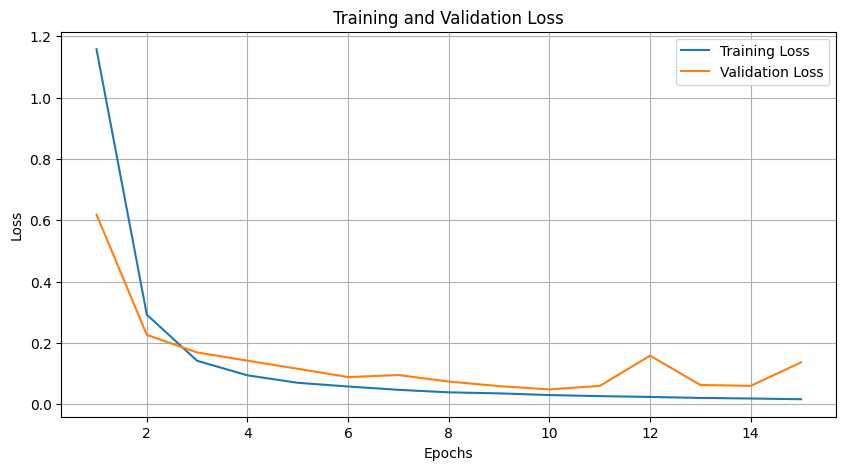

In [91]:
cnn_model = CNN()
# define train/val/test loaders, choose a batch size
batch_size = 1024
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size)
# Train the model
trained_cnn, train_losses, val_losses = train_model(
    model=cnn_model,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=20,
    patience=5,
    learning_rate=0.001
)


In [97]:
# Define a dataloader for the test set and extract activations for 1000 test samples
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1000)
test_images, test_labels = next(iter(test_loader))
cnn_acts_trained, layer_names = extract_activations(trained_cnn, test_images, test_labels)

alphas, radii, dims, mean_alphas, mean_radii, mean_dims = capacity_analysis(cnn_acts_trained, layer_names)

Processing activations for layer: inputs
Processing activations for layer: conv_0
Processing activations for layer: conv_1
Processing activations for layer: conv_2
Processing activations for layer: conv_3
Processing activations for layer: linear_0


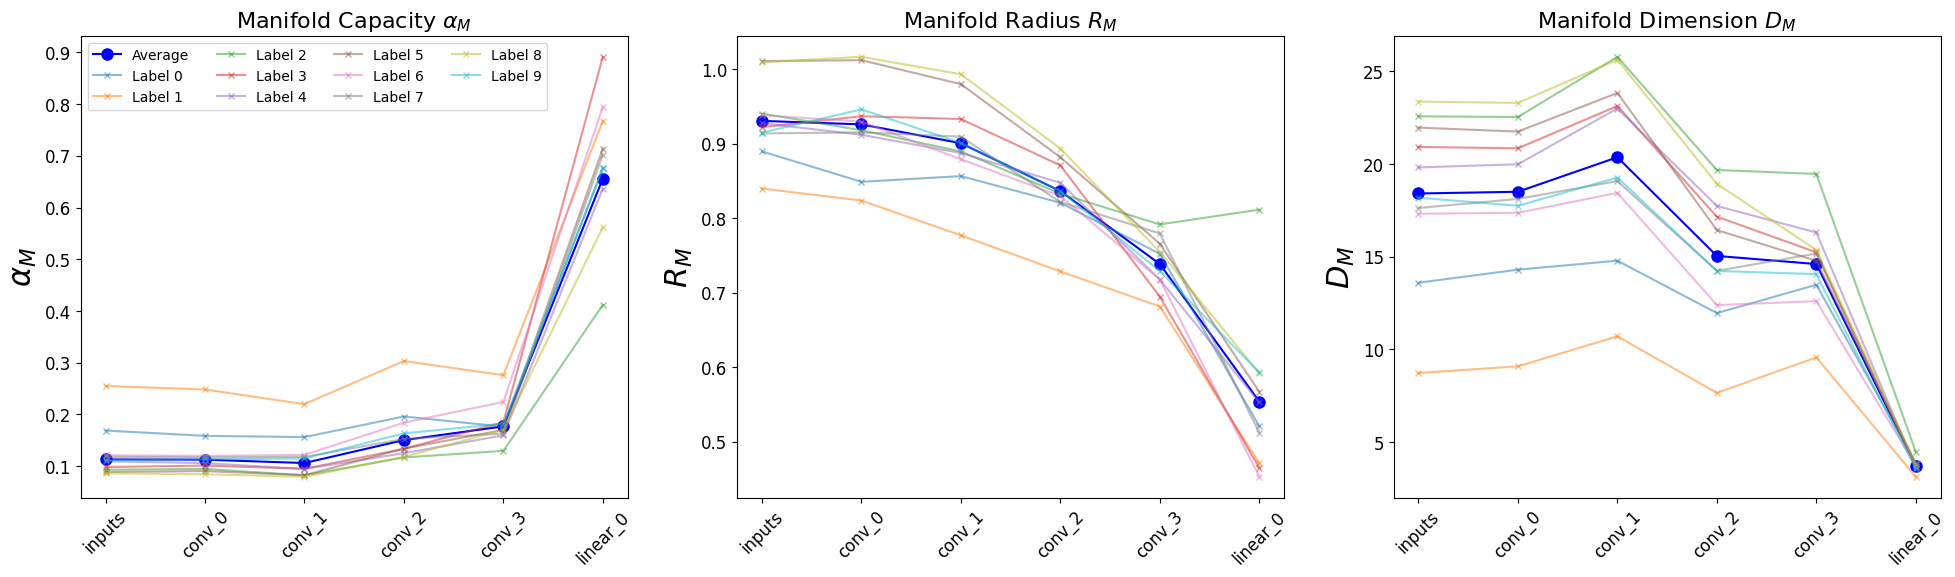

In [98]:
# Create a figure with 3 subplots side by side
fig, axes = plt.subplots(1, 3, figsize=(24, 6))

# X-axis labels for all plots
x_labels = ['inputs'] + layer_names
x_values = np.arange(len(x_labels))

# Plot alpha values (a)
plt.sca(axes[0])
plt.plot(x_values, mean_alphas, 'o-', color='blue', markersize=8,label='Average')
for l in mnist_labels:
    plt.plot(x_values, alphas[l], 'x-', markersize=4, alpha=0.5, label=f'Label {l}')
plt.legend(loc='upper left', fontsize=10,ncol=4)
plt.xticks(x_values, labels=x_labels, rotation=45, fontsize=12)
plt.title(r"Manifold Capacity $\alpha_M$",fontsize=16)
plt.ylabel(r"$\alpha_M$", fontsize=22)
plt.yticks(fontsize=12)

# Plot R values (a)
plt.sca(axes[1])
plt.plot(x_values, mean_radii, 'o-', color='blue', markersize=8)
for l in mnist_labels:
    plt.plot(x_values, radii[l], 'x-', markersize=4, alpha=0.5)
plt.xticks(x_values, labels=x_labels, rotation=45, fontsize=12)
plt.title(r"Manifold Radius $R_M$",fontsize=16)
plt.ylabel(r"$R_M$", fontsize=22)
plt.yticks(fontsize=12)

# Plot D values (a)
plt.sca(axes[2])
plt.plot(x_values, mean_dims, 'o-', color='blue', markersize=8)
for l in mnist_labels:
    plt.plot(x_values, dims[l], 'x-', markersize=4, alpha=0.5)
plt.xticks(x_values, labels=x_labels, rotation=45, fontsize=12)
plt.title(r"Manifold Dimension $D_M$",fontsize=16)
plt.ylabel(r"$D_M$", fontsize=22)
_=plt.yticks(fontsize=12)

## 2.2 - Analyze a pre-trained ResNet on ImageNet

In [18]:
model = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar10_resnet20", pretrained=True)
model.eval()

cifar10_mean = [0.4914, 0.4822, 0.4465]
cifar10_std = [0.2023, 0.1994, 0.2010]
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=cifar10_mean, std=cifar10_std),
])
dataset = datasets.CIFAR10('./data',train=False, transform=transform, download=True)

# Function to extract activations from ResNet18
def extract_resnet18_activations(model, images, labels, num_samples=-1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()
    
    # Only process the requested number of samples
    if len(images) > num_samples and num_samples > 0:
        indices = torch.randperm(len(images))[:num_samples]
        images = images[indices]
        labels = labels[indices]
    
    images = images.to(device)
    
    # Initialize activations dictionary
    activations = {}
    activations['inputs'] = images.view(images.shape[0], -1).cpu().numpy()
    activations['labels'] = labels.cpu().numpy()
    
    # Define hooks for all layers we want to capture
    hooks = []
    layer_idx = {'conv': 0, 'bn': 0, 'relu': 0, 'maxpool': 0, 'layer': 0, 'avgpool': 0, 'fc': 0}
    
    def get_activation(name):
        def hook(model, input, output):
            # flatten the output (e.g. if conv layer)
            activations[name] = output.detach().cpu().numpy().reshape(output.shape[0], -1)
        return hook
    
    # Register hooks for each layer in ResNet18
    for name, module in model.named_modules():
        if isinstance(module, torch.nn.Conv2d):
            layer_name = f"conv_{layer_idx['conv']}"
            hooks.append(module.register_forward_hook(get_activation(layer_name)))
            layer_idx['conv'] += 1
        elif isinstance(module, torch.nn.BatchNorm2d):
            layer_name = f"bn_{layer_idx['bn']}"
            hooks.append(module.register_forward_hook(get_activation(layer_name)))
            layer_idx['bn'] += 1
        elif isinstance(module, torch.nn.ReLU):
            layer_name = f"relu_{layer_idx['relu']}"
            hooks.append(module.register_forward_hook(get_activation(layer_name)))
            layer_idx['relu'] += 1
        elif isinstance(module, torch.nn.MaxPool2d):
            layer_name = f"maxpool_{layer_idx['maxpool']}"
            hooks.append(module.register_forward_hook(get_activation(layer_name)))
            layer_idx['maxpool'] += 1
        elif isinstance(module, torch.nn.AdaptiveAvgPool2d):
            layer_name = f"avgpool_{layer_idx['avgpool']}"
            hooks.append(module.register_forward_hook(get_activation(layer_name)))
            layer_idx['avgpool'] += 1
        elif isinstance(module, torch.nn.Linear):
            layer_name = f"fc_{layer_idx['fc']}"
            hooks.append(module.register_forward_hook(get_activation(layer_name)))
            layer_idx['fc'] += 1
    
    # Forward pass to collect activations
    with torch.no_grad():
        model(images)
    
    # Remove all hooks
    for hook in hooks:
        hook.remove()
    
    # Get layer names
    layer_names = [key for key in activations.keys() if key not in ['inputs', 'labels']]
    # project to 5000 dimensions if larger
    for name in layer_names:
        #print(f"Layer {name} has dim {activations[name].shape[1]}")
        if activations[name].shape[1] > 5000:
            print(f"Projecting layer {name} from {activations[name].shape[1]} to 5000 dimensions")
            M = np.random.randn(5000, activations[name].shape[1])
            M /= np.sqrt(np.sum(M*M, axis=1, keepdims=True))
            activations[name] = np.matmul(activations[name], M.T)

    return activations, layer_names

Using cache found in /n/home11/sambt/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


In [19]:
# Define a dataloader for the test set and extract activations for 1000 test samples
test_loader = torch.utils.data.DataLoader(dataset, batch_size=200, shuffle=True)
test_images, test_labels = next(iter(test_loader))
imagenette_labels = sorted(list(set(test_labels.numpy())))
activations_resnet, layer_names = extract_resnet18_activations(model, test_images, test_labels)

Projecting layer conv_0 from 16384 to 5000 dimensions
Projecting layer bn_0 from 16384 to 5000 dimensions
Projecting layer relu_0 from 16384 to 5000 dimensions
Projecting layer conv_1 from 16384 to 5000 dimensions
Projecting layer bn_1 from 16384 to 5000 dimensions
Projecting layer relu_1 from 16384 to 5000 dimensions
Projecting layer conv_2 from 16384 to 5000 dimensions
Projecting layer bn_2 from 16384 to 5000 dimensions
Projecting layer conv_3 from 16384 to 5000 dimensions
Projecting layer bn_3 from 16384 to 5000 dimensions
Projecting layer relu_2 from 16384 to 5000 dimensions
Projecting layer conv_4 from 16384 to 5000 dimensions
Projecting layer bn_4 from 16384 to 5000 dimensions
Projecting layer conv_5 from 16384 to 5000 dimensions
Projecting layer bn_5 from 16384 to 5000 dimensions
Projecting layer relu_3 from 16384 to 5000 dimensions
Projecting layer conv_6 from 16384 to 5000 dimensions
Projecting layer bn_6 from 16384 to 5000 dimensions
Projecting layer conv_7 from 8192 to 5000 

In [20]:
alphas, radii, dims, mean_alphas, mean_radii, mean_dims = capacity_analysis(activations_resnet, layer_names)

Processing activations for layer: inputs
Processing activations for layer: conv_0
Processing activations for layer: bn_0
Processing activations for layer: relu_0
Processing activations for layer: conv_1
Processing activations for layer: bn_1
Processing activations for layer: relu_1
Processing activations for layer: conv_2
Processing activations for layer: bn_2
Processing activations for layer: conv_3
Processing activations for layer: bn_3
Processing activations for layer: relu_2
Processing activations for layer: conv_4
Processing activations for layer: bn_4
Processing activations for layer: conv_5
Processing activations for layer: bn_5
Processing activations for layer: relu_3
Processing activations for layer: conv_6
Processing activations for layer: bn_6
Processing activations for layer: conv_7
Processing activations for layer: bn_7
Processing activations for layer: relu_4
Processing activations for layer: conv_8
Processing activations for layer: bn_8
Processing activations for layer: 

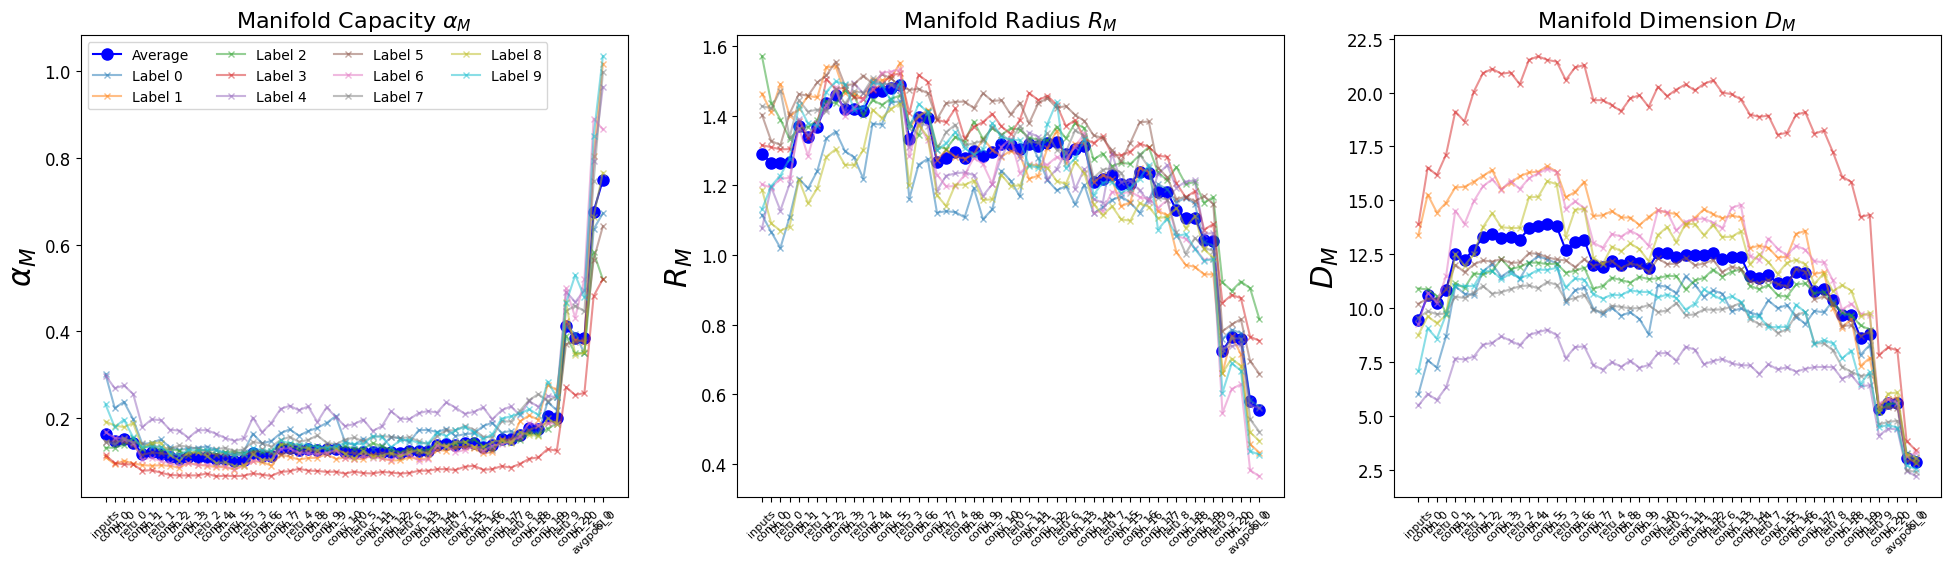

In [22]:
# Create a figure with 3 subplots side by side
fig, axes = plt.subplots(1, 3, figsize=(24, 6))

# X-axis labels for all plots
x_labels = ['inputs'] + layer_names
x_values = np.arange(len(x_labels))

# Plot alpha values (a)
plt.sca(axes[0])
plt.plot(x_values, mean_alphas, 'o-', color='blue', markersize=8,label='Average')
for l in imagenette_labels:
    plt.plot(x_values, alphas[l], 'x-', markersize=4, alpha=0.5, label=f'Label {l}')
plt.legend(loc='upper left', fontsize=10,ncol=4)
plt.xticks(x_values, labels=x_labels, rotation=45, fontsize=8)
plt.title(r"Manifold Capacity $\alpha_M$",fontsize=16)
plt.ylabel(r"$\alpha_M$", fontsize=22)
plt.yticks(fontsize=12)

# Plot R values (a)
plt.sca(axes[1])
plt.plot(x_values, mean_radii, 'o-', color='blue', markersize=8)
for l in imagenette_labels:
    plt.plot(x_values, radii[l], 'x-', markersize=4, alpha=0.5)
plt.xticks(x_values, labels=x_labels, rotation=45, fontsize=8)
plt.title(r"Manifold Radius $R_M$",fontsize=16)
plt.ylabel(r"$R_M$", fontsize=22)
plt.yticks(fontsize=12)

# Plot D values (a)
plt.sca(axes[2])
plt.plot(x_values, mean_dims, 'o-', color='blue', markersize=8)
for l in imagenette_labels:
    plt.plot(x_values, dims[l], 'x-', markersize=4, alpha=0.5)
plt.xticks(x_values, labels=x_labels, rotation=45, fontsize=8)
plt.title(r"Manifold Dimension $D_M$",fontsize=16)
plt.ylabel(r"$D_M$", fontsize=22)
_=plt.yticks(fontsize=12)

What trends do you notice here? How do they compare to what you observed for the two "simple" models above?

Now try it with the variant of manifold capacity that corrects for correlations between the centroids of class manifolds:

In [27]:
alphas, radii, dims, mean_alphas, mean_radii, mean_dims = capacity_analysis(activations_resnet, layer_names, correlation_corrected=True)

Processing activations for layer: inputs
Processing activations for layer: conv_0
Processing activations for layer: bn_0
Processing activations for layer: relu_0
Processing activations for layer: conv_1
Processing activations for layer: bn_1
Processing activations for layer: relu_1
Processing activations for layer: conv_2
Processing activations for layer: bn_2
Processing activations for layer: conv_3
Processing activations for layer: bn_3
Processing activations for layer: relu_2
Processing activations for layer: conv_4
Processing activations for layer: bn_4
Processing activations for layer: conv_5
Processing activations for layer: bn_5
Processing activations for layer: relu_3
Processing activations for layer: conv_6
Processing activations for layer: bn_6
Processing activations for layer: conv_7
Processing activations for layer: bn_7
Processing activations for layer: relu_4
Processing activations for layer: conv_8
Processing activations for layer: bn_8
Processing activations for layer: 

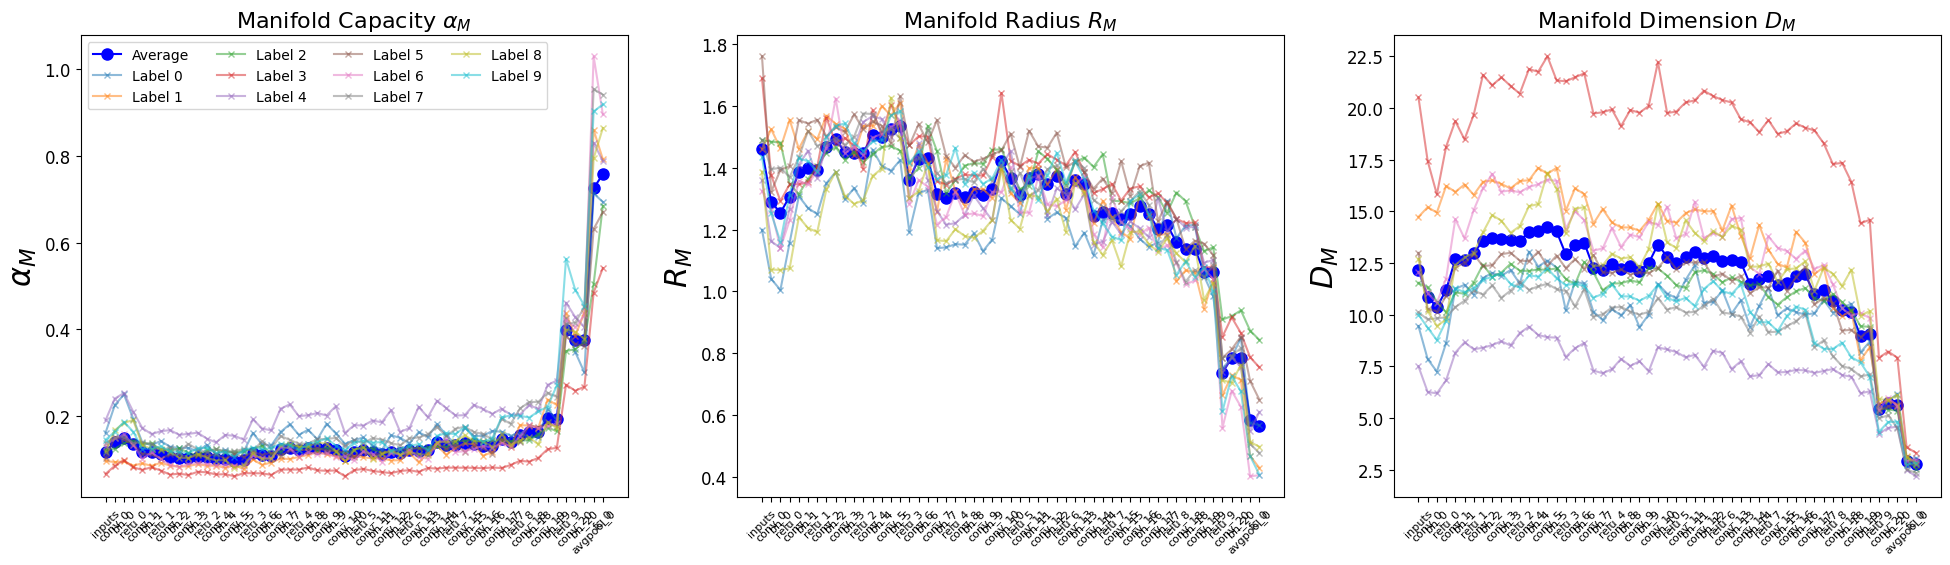

In [28]:
# Create a figure with 3 subplots side by side
fig, axes = plt.subplots(1, 3, figsize=(24, 6))

# X-axis labels for all plots
x_labels = ['inputs'] + layer_names
x_values = np.arange(len(x_labels))

# Plot alpha values (a)
plt.sca(axes[0])
plt.plot(x_values, mean_alphas, 'o-', color='blue', markersize=8,label='Average')
for l in imagenette_labels:
    plt.plot(x_values, alphas[l], 'x-', markersize=4, alpha=0.5, label=f'Label {l}')
plt.legend(loc='upper left', fontsize=10,ncol=4)
plt.xticks(x_values, labels=x_labels, rotation=45, fontsize=8)
plt.title(r"Manifold Capacity $\alpha_M$",fontsize=16)
plt.ylabel(r"$\alpha_M$", fontsize=22)
plt.yticks(fontsize=12)

# Plot R values (a)
plt.sca(axes[1])
plt.plot(x_values, mean_radii, 'o-', color='blue', markersize=8)
for l in imagenette_labels:
    plt.plot(x_values, radii[l], 'x-', markersize=4, alpha=0.5)
plt.xticks(x_values, labels=x_labels, rotation=45, fontsize=8)
plt.title(r"Manifold Radius $R_M$",fontsize=16)
plt.ylabel(r"$R_M$", fontsize=22)
plt.yticks(fontsize=12)

# Plot D values (a)
plt.sca(axes[2])
plt.plot(x_values, mean_dims, 'o-', color='blue', markersize=8)
for l in imagenette_labels:
    plt.plot(x_values, dims[l], 'x-', markersize=4, alpha=0.5)
plt.xticks(x_values, labels=x_labels, rotation=45, fontsize=8)
plt.title(r"Manifold Dimension $D_M$",fontsize=16)
plt.ylabel(r"$D_M$", fontsize=22)
_=plt.yticks(fontsize=12)